**Data Inspection, Cleaning and Preparation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import numpy as np
import os

In [3]:
def df_check(df_to_check):
    """Function to generate information for a data frame"""
    # Generate a summary for NaN, zero and unique values
    nan_count = df_to_check.isna().sum()
    unique_count = df_to_check.nunique()
    zero_count = (df_to_check == 0).sum()
    data_type = df_to_check.dtypes

    # Merge the summaries into one dataframe for inspection
    df_check = pd.concat([nan_count,unique_count, zero_count, data_type],axis =1)
    df_check.columns = ['NaN Count','Unique Count','Zero Count', 'Data Type']
    print(df_check)


In [4]:
# Function to load a CSV file into a DataFrame
def load_csv(file_path, parse_dates=None, dtype=None):
    """Load a CSV file into a DataFrame."""
    return pd.read_csv(file_path, sep=',', header=0, parse_dates=parse_dates, dtype=dtype)


In [5]:
# Function to preprocess demand data (convert to datetime and aggregate)
def preprocess_demand_data(df, date_format='%d/%m/%Y %H:%M', freq='D'):
    """Convert DATETIME to datetime format and aggregate the demand data by frequency."""
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format=date_format)
    df.set_index('DATETIME', inplace=True)
    df.drop('REGIONID', axis=1, inplace=True)
    return df.resample(freq).mean()

In [6]:
# Function to preprocess temperature data (convert to datetime and calculate mean)
def preprocess_temperature_data(df, date_format='%d/%m/%Y %H:%M', freq='D'):
    """Convert DATETIME to datetime format and calculate mean temperature by frequency."""
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format=date_format)
    df.set_index('DATETIME', inplace=True)
    df.drop('LOCATION', axis=1, inplace=True)
    return df.resample(freq).mean()

In [7]:
# Function to preprocess SILO data
def preprocess_silo_data(df, freq='D'):
    """Select relevant columns, calculate RH, and aggregate SILO data by frequency."""
    df['Date2'] = pd.to_datetime(df['Date2'], format='%d/%m/%Y')
    df['RH'] = (df['RHmaxT'] + df['RHminT']) / 2  # Calculate RH as the average of RHMaxT and RHminT
    df_filtered = df[['Date2', 'Rain', 'Evap', 'Radn', 'VP', 'RH']]  # Select relevant columns
    df_filtered.set_index('Date2', inplace=True)

    # Aggregating data based on frequency
    if freq == 'D':
        return df_filtered.resample(freq).mean()
    else:
        agg_dict = {
            'Rain': 'sum',
            'Evap': 'sum',
            'Radn': 'sum',
            'VP': 'sum',
            'RH': 'mean'
        }
        return df_filtered.resample(freq).agg(agg_dict)

In [8]:
# Function to perform all preprocessing steps
def preprocess_all_data(demand_file, temp_file, silo_file, demand_date_format, temp_date_format, freq='D'):
    """Load, preprocess demand, temperature, and SILO data."""
    # Load the data
    demand_df = load_csv(demand_file, parse_dates=['DATETIME'], dtype={'TOTALDEMAND': float, 'REGIONID': str})
    temp_df = load_csv(temp_file, parse_dates=['DATETIME'])
    silo_df = load_csv(silo_file, parse_dates=['Date2'])

    # Preprocess the data
    demand_processed_df = preprocess_demand_data(demand_df, date_format=demand_date_format, freq=freq)
    temp_processed_df = preprocess_temperature_data(temp_df, date_format=temp_date_format, freq=freq)
    silo_processed_df = preprocess_silo_data(silo_df, freq=freq)

    # Data Check
    print(f"Data check for {demand_file.split('/')[-1]}:")
    df_check(demand_processed_df)
    print("\n")
    print(f"Data check for {temp_file.split('/')[-1]}:")
    df_check(temp_processed_df)
    print("\n")
    print(f"Data check for {silo_file.split('/')[-1]}:")
    df_check(silo_processed_df)

    return demand_processed_df, temp_processed_df, silo_processed_df

In [9]:
# Function to preprocess wildfire data with specified date format
def preprocess_wildfire_data(file_path, date_format='%d/%m/%Y'):
    """Load and preprocess wildfire data with the specified date format."""
    # Load the data
    wildfire_df = pd.read_csv(file_path)
    # Convert StartDate and EndDate to datetime format with the given date format
    wildfire_df['StartDate'] = pd.to_datetime(wildfire_df['StartDate'], format=date_format)
    wildfire_df['EndDate'] = pd.to_datetime(wildfire_df['EndDate'], format=date_format)
    return wildfire_df

In [10]:
# Function to integrate wildfire data into daily DataFrame
def integrate_wildfire_data(daily_df, wildfire_df):
    """Integrate wildfire data into the daily DataFrame by adding count_wf and area_wf columns."""
    # Initialize new columns
    daily_df['count_wf'] = 0
    daily_df['area_wf'] = 0.0

    # Iterate through wildfire records
    for _, row in wildfire_df.iterrows():
        # Check for dates within the range
        mask = (daily_df.index >= row['StartDate']) & (daily_df.index <= row['EndDate'])
        daily_df.loc[mask, 'count_wf'] += 1
        daily_df.loc[mask, 'area_wf'] += row['area_ha']

    return daily_df

In [11]:
# Set the working directory
os.chdir('/content/drive/MyDrive/data/Group10_project')

# File paths
nsw_demand_file = 'data/Raw Files/totaldemand_nsw.csv'
qld_demand_file = 'data/Raw Files/totaldemand_qld.csv'
nsw_temp_file = 'data/Raw Files/temperature_nsw.csv'
qld_temp_file = 'data/Raw Files/temprature_qld.csv'
nsw_silo_file = 'data/Raw Files/66137 BANKSTOWN.csv'
qld_silo_file = 'data/Raw Files/40842 BRISBANE.csv'
nsw_wildfire_file = 'data/Raw Files/nsw_wildfire.csv'
qld_wildfire_file = 'data/Raw Files/qld_wildfire.csv'

In [12]:
# Preprocess NSW data
daily_totaldemand_nsw, daily_temperature_nsw, daily_silo_nsw = preprocess_all_data(
    nsw_demand_file, nsw_temp_file, nsw_silo_file, '%d/%m/%Y %H:%M', '%d/%m/%Y %H:%M', freq='D'
)

# Preprocess QLD data
daily_totaldemand_qld, daily_temperature_qld, daily_silo_qld = preprocess_all_data(
    qld_demand_file, qld_temp_file, qld_silo_file, '%d/%m/%Y %H:%M', '%d/%m/%Y %H:%M', freq='D'
)

# Preprocess wildfire data for NSW with date format 'day/month/year'
nsw_wildfire_df = preprocess_wildfire_data(nsw_wildfire_file, date_format='%d/%m/%Y')
qld_wildfire_df = preprocess_wildfire_data(qld_wildfire_file, date_format='%Y-%m-%d')

Data check for totaldemand_nsw.csv:
             NaN Count  Unique Count  Zero Count Data Type
TOTALDEMAND          0          4095           0   float64


Data check for temperature_nsw.csv:
             NaN Count  Unique Count  Zero Count Data Type
TEMPERATURE          3          3938           0   float64


Data check for 66137 BANKSTOWN.csv:
      NaN Count  Unique Count  Zero Count Data Type
Rain          0           234        3592   float64
Evap          0           129           1   float64
Radn          0           327           0   float64
VP            0           204           0   float64
RH            0          1287           0   float64
Data check for totaldemand_qld.csv:
             NaN Count  Unique Count  Zero Count Data Type
TOTALDEMAND          0          4094           0   float64


Data check for temprature_qld.csv:
             NaN Count  Unique Count  Zero Count Data Type
TEMPERATURE          7          3767           0   float64


Data check for 40842 BRISBANE

In [13]:
# Function to generate aggregates based on the dataframe columns and frequency
def generate_aggregates(df, freq='W-MON'):
    """Generate aggregates based on frequency and available columns in the dataframe."""
    # Define the aggregation rules based on available columns in the dataframe
    agg_dict = {}

    # Check and add aggregation rules based on column presence
    if 'Rain' in df.columns:
        agg_dict['Rain'] = 'sum'
    if 'Evap' in df.columns:
        agg_dict['Evap'] = 'sum'
    if 'Radn' in df.columns:
        agg_dict['Radn'] = 'sum'
    if 'VP' in df.columns:
        agg_dict['VP'] = 'sum'
    if 'RH' in df.columns:
        agg_dict['RH'] = 'mean'
    if 'TOTALDEMAND' in df.columns:
        agg_dict['TOTALDEMAND'] = 'mean'
    if 'TEMPERATURE' in df.columns:
        agg_dict['TEMPERATURE'] = 'mean'

    # If no specific aggregation rules are needed, just use sum for numeric columns
    if not agg_dict:
        return df.resample(freq).sum()

    # Aggregate based on the defined aggregation rules
    return df.resample(freq).agg(agg_dict)

# Weekly aggregates
weekly_totaldemand_nsw = generate_aggregates(daily_totaldemand_nsw, freq='W-MON')
weekly_totaldemand_qld = generate_aggregates(daily_totaldemand_qld, freq='W-MON')
weekly_temperature_nsw = generate_aggregates(daily_temperature_nsw, freq='W-MON')
weekly_temperature_qld = generate_aggregates(daily_temperature_qld, freq='W-MON')
weekly_silo_nsw = generate_aggregates(daily_silo_nsw, freq='W-MON')
weekly_silo_qld = generate_aggregates(daily_silo_qld, freq='W-MON')

# Monthly aggregates
monthly_totaldemand_nsw = generate_aggregates(daily_totaldemand_nsw, freq='M')
monthly_totaldemand_qld = generate_aggregates(daily_totaldemand_qld, freq='M')
monthly_temperature_nsw = generate_aggregates(daily_temperature_nsw, freq='M')
monthly_temperature_qld = generate_aggregates(daily_temperature_qld, freq='M')
monthly_silo_nsw = generate_aggregates(daily_silo_nsw, freq='M')
monthly_silo_qld = generate_aggregates(daily_silo_qld, freq='M')

In [14]:
# Function to merge demand, temperature, and SILO data
def merge_dataframes(demand_df, temp_df, silo_df, join_type='left'):
    """
    Merge demand, temperature, and SILO dataframes using the specified join type.
    Arguments:
    - demand_df: DataFrame containing demand data.
    - temp_df: DataFrame containing temperature data.
    - silo_df: DataFrame containing SILO data.
    - join_type: Type of join to be used for merging (default is 'left').
    Returns:
    - merged_df: DataFrame with merged data.
    """
    # Merge demand and temperature data
    merged_df = demand_df.merge(temp_df, how=join_type, left_index=True, right_index=True)
    # Merge the result with SILO data
    merged_df = merged_df.merge(silo_df, how=join_type, left_index=True, right_index=True)
    return merged_df

# Merge daily data
daily_merged_nsw = merge_dataframes(daily_totaldemand_nsw, daily_temperature_nsw, daily_silo_nsw).round(2)
daily_merged_qld = merge_dataframes(daily_totaldemand_qld, daily_temperature_qld, daily_silo_qld).round(2)

# Merge weekly data
weekly_merged_nsw = merge_dataframes(weekly_totaldemand_nsw, weekly_temperature_nsw, weekly_silo_nsw).round(2)
weekly_merged_qld = merge_dataframes(weekly_totaldemand_qld, weekly_temperature_qld, weekly_silo_qld).round(2)

# Merge monthly data
monthly_merged_nsw = merge_dataframes(monthly_totaldemand_nsw, monthly_temperature_nsw, monthly_silo_nsw).round(2)
monthly_merged_qld = merge_dataframes(monthly_totaldemand_qld, monthly_temperature_qld, monthly_silo_qld).round(2)

# Display the merged data
print("Daily Merged NSW Data:")
print(daily_merged_nsw.head())

print("\nWeekly Merged NSW Data:")
print(weekly_merged_nsw.head())

print("\nMonthly Merged NSW Data:")
print(monthly_merged_nsw.head())

print("Daily Merged QLD Data:")
print(daily_merged_qld.head())

print("\nWeekly Merged QLD Data:")
print(weekly_merged_qld.head())

print("\nMonthly Merged QLD Data:")
print(monthly_merged_qld.head())


Daily Merged NSW Data:
            TOTALDEMAND  TEMPERATURE  Rain  Evap  Radn    VP     RH
DATETIME                                                           
2010-01-01      7801.35        25.09   0.2   5.2  14.6  23.1  76.35
2010-01-02      8017.46        24.77   0.0   5.9  18.4  22.0  67.80
2010-01-03      7399.90        19.43  15.2   1.9   7.3  19.1  83.25
2010-01-04      8241.72        20.63   0.2   3.4  14.4  18.2  75.15
2010-01-05      8827.81        22.66   0.0   6.8  28.1  16.9  65.35

Weekly Merged NSW Data:
            TOTALDEMAND  TEMPERATURE  Rain  Evap   Radn     VP     RH
DATETIME                                                             
2010-01-04      7865.11        22.48  15.6  16.4   54.7   82.4  75.64
2010-01-11      9038.70        23.79   0.4  46.8  184.1  130.2  63.35
2010-01-18      9017.14        22.72   8.4  44.6  156.7  132.6  65.55
2010-01-25      9307.42        23.59   3.2  51.9  177.0  112.4  55.84
2010-02-01      9161.89        23.98  15.2  38.0  139.9 

In [15]:
# Integrate wildfire data into daily DataFrames for NSW and QLD
daily_merged_nsw = integrate_wildfire_data(daily_merged_nsw, nsw_wildfire_df)
daily_merged_qld = integrate_wildfire_data(daily_merged_qld, qld_wildfire_df)

In [16]:
# Display the updated daily dataframes (optional)
print("Daily Merged NSW Data with Wildfire Information:")
print(daily_merged_nsw.head())

print("\nDaily Merged QLD Data with Wildfire Information:")
print(daily_merged_qld.head())

Daily Merged NSW Data with Wildfire Information:
            TOTALDEMAND  TEMPERATURE  Rain  Evap  Radn    VP     RH  count_wf  \
DATETIME                                                                        
2010-01-01      7801.35        25.09   0.2   5.2  14.6  23.1  76.35         3   
2010-01-02      8017.46        24.77   0.0   5.9  18.4  22.0  67.80         3   
2010-01-03      7399.90        19.43  15.2   1.9   7.3  19.1  83.25         3   
2010-01-04      8241.72        20.63   0.2   3.4  14.4  18.2  75.15         3   
2010-01-05      8827.81        22.66   0.0   6.8  28.1  16.9  65.35         0   

               area_wf  
DATETIME                
2010-01-01  429.667597  
2010-01-02  429.667597  
2010-01-03  429.667597  
2010-01-04  429.667597  
2010-01-05    0.000000  

Daily Merged QLD Data with Wildfire Information:
            TOTALDEMAND  TEMPERATURE  Rain  Evap  Radn    VP     RH  count_wf  \
DATETIME                                                                     

In [17]:
def export_to_csv(df, filename):
    """
    Export a DataFrame to a CSV file.
    Arguments:
    - df: DataFrame to be exported.
    - filename: Name of the CSV file.
    """
    df.to_csv(filename, index=True)
    print(f"DataFrame successfully exported to {filename}")

# Export daily merged data to CSV files
export_to_csv(daily_merged_nsw, 'daily_merged_nsw.csv')
export_to_csv(daily_merged_qld, 'daily_merged_qld.csv')

# Export weekly merged data to CSV files
export_to_csv(weekly_merged_nsw, 'weekly_merged_nsw.csv')
export_to_csv(weekly_merged_qld, 'weekly_merged_qld.csv')

# Export monthly merged data to CSV files
export_to_csv(monthly_merged_nsw, 'monthly_merged_nsw.csv')
export_to_csv(monthly_merged_qld, 'monthly_merged_qld.csv')

DataFrame successfully exported to daily_merged_nsw.csv
DataFrame successfully exported to daily_merged_qld.csv
DataFrame successfully exported to weekly_merged_nsw.csv
DataFrame successfully exported to weekly_merged_qld.csv
DataFrame successfully exported to monthly_merged_nsw.csv
DataFrame successfully exported to monthly_merged_qld.csv


Exploratory Data Analysis for NSW

Basic Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4095 entries, 2010-01-01 to 2021-03-18
Freq: D
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOTALDEMAND  4095 non-null   float64
 1   TEMPERATURE  4092 non-null   float64
 2   Rain         4095 non-null   float64
 3   Evap         4095 non-null   float64
 4   Radn         4095 non-null   float64
 5   VP           4095 non-null   float64
 6   RH           4095 non-null   float64
 7   count_wf     4095 non-null   int64  
 8   area_wf      4095 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 319.9 KB
None

Summary Statistics:
        TOTALDEMAND  TEMPERATURE         Rain         Evap         Radn  \
count   4095.000000  4092.000000  4095.000000  4095.000000  4095.000000   
mean    8112.902303    17.412537     2.315653     4.184762    15.996532   
std      798.622494     4.692215     8.277924    

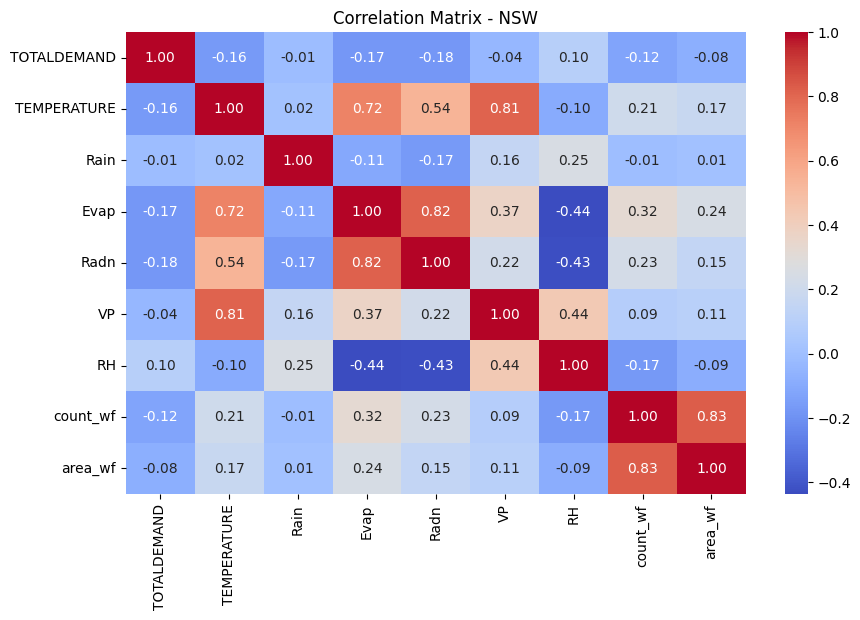

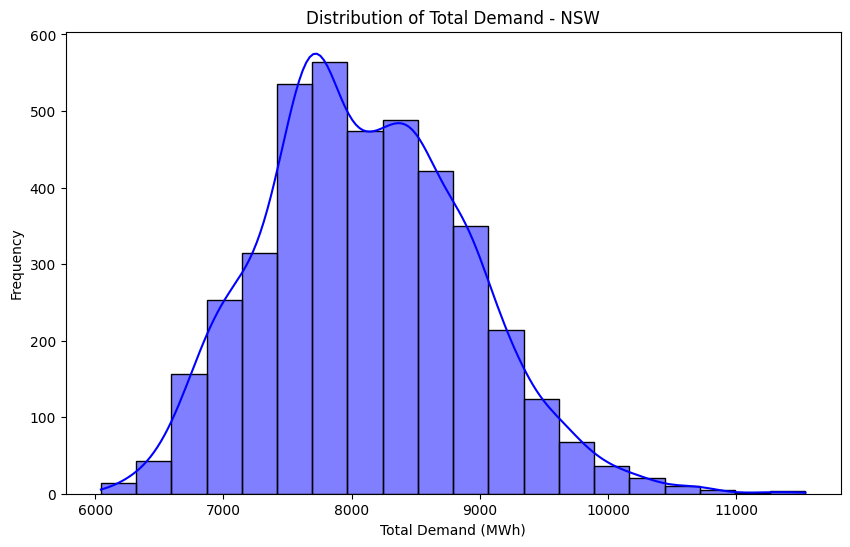

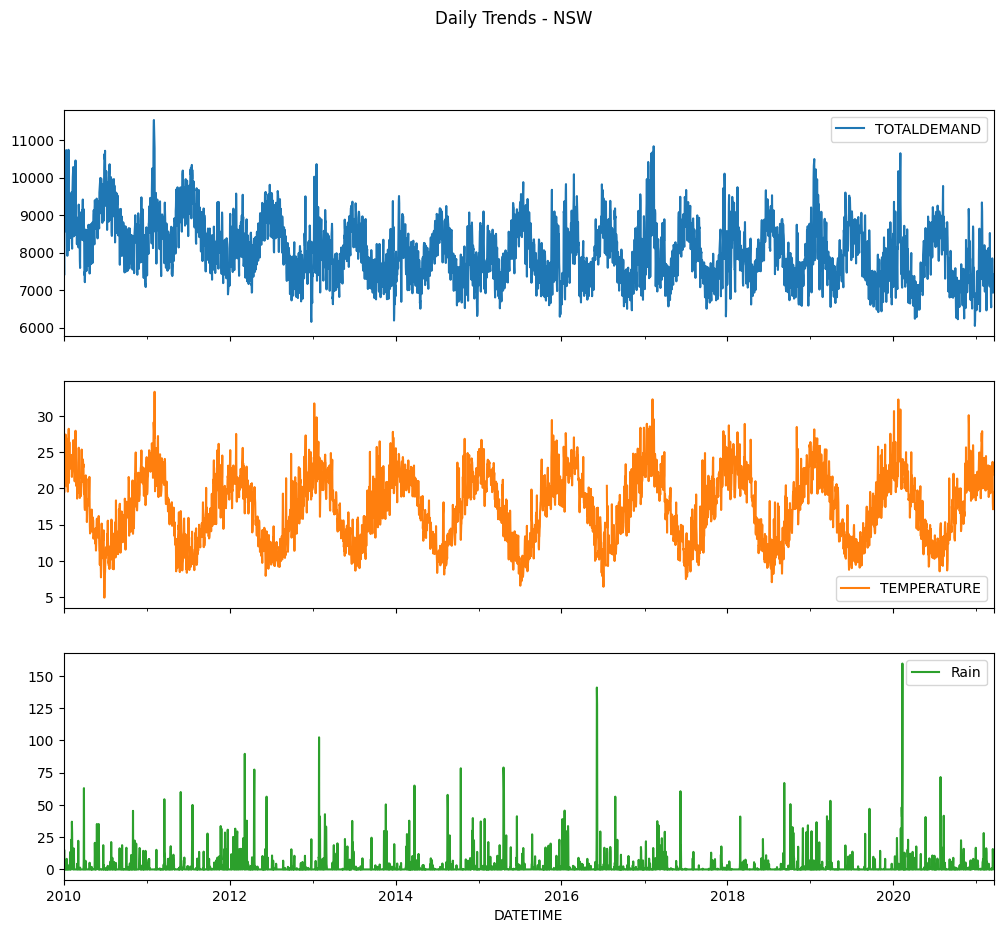

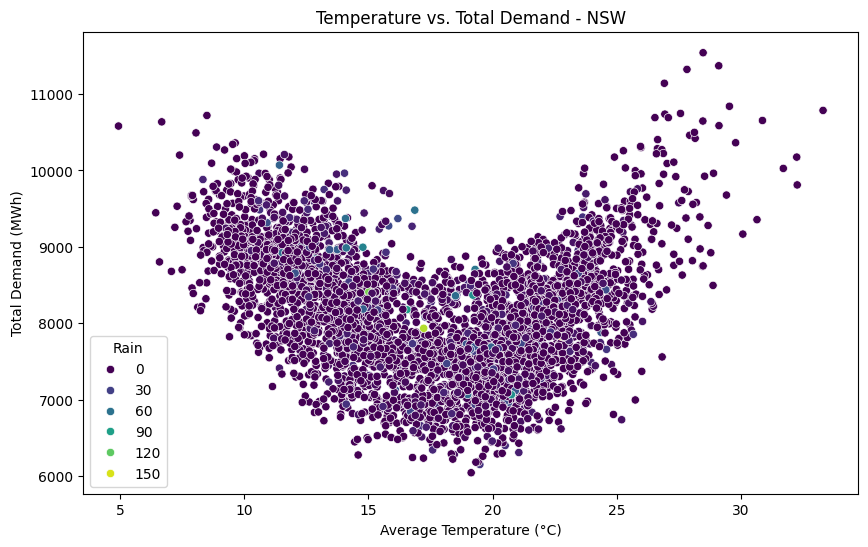

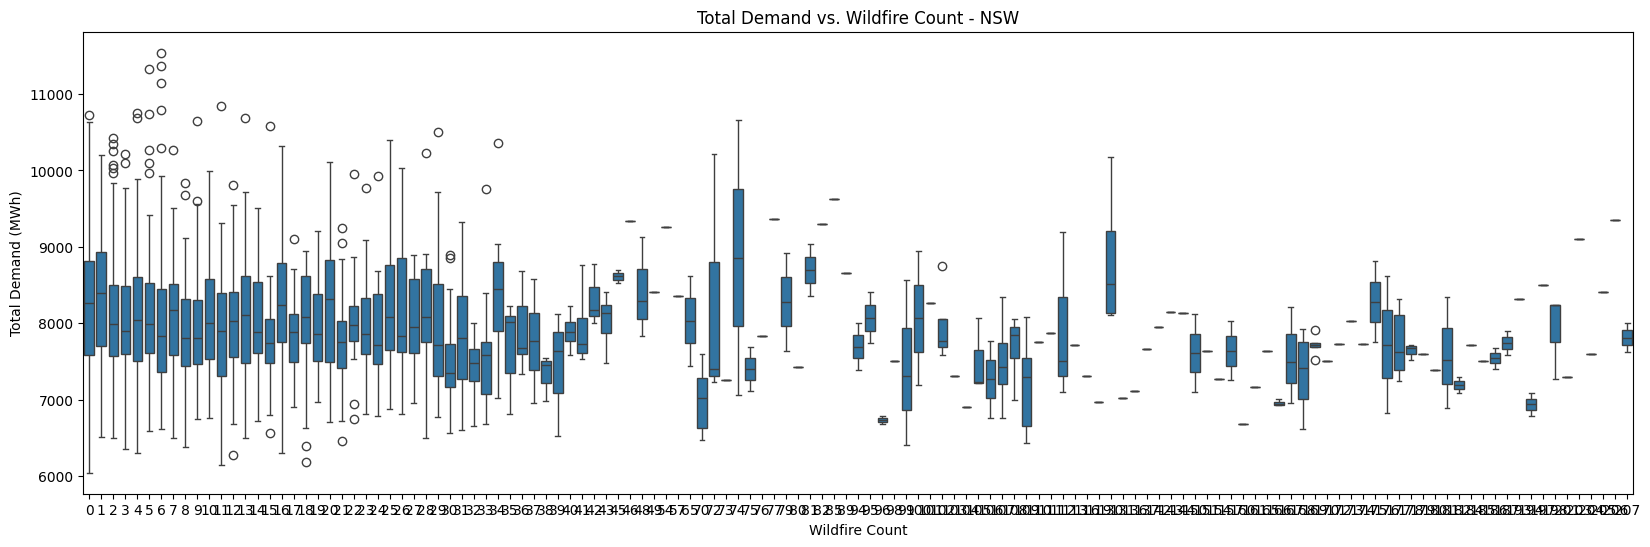

<Figure size 1200x800 with 0 Axes>

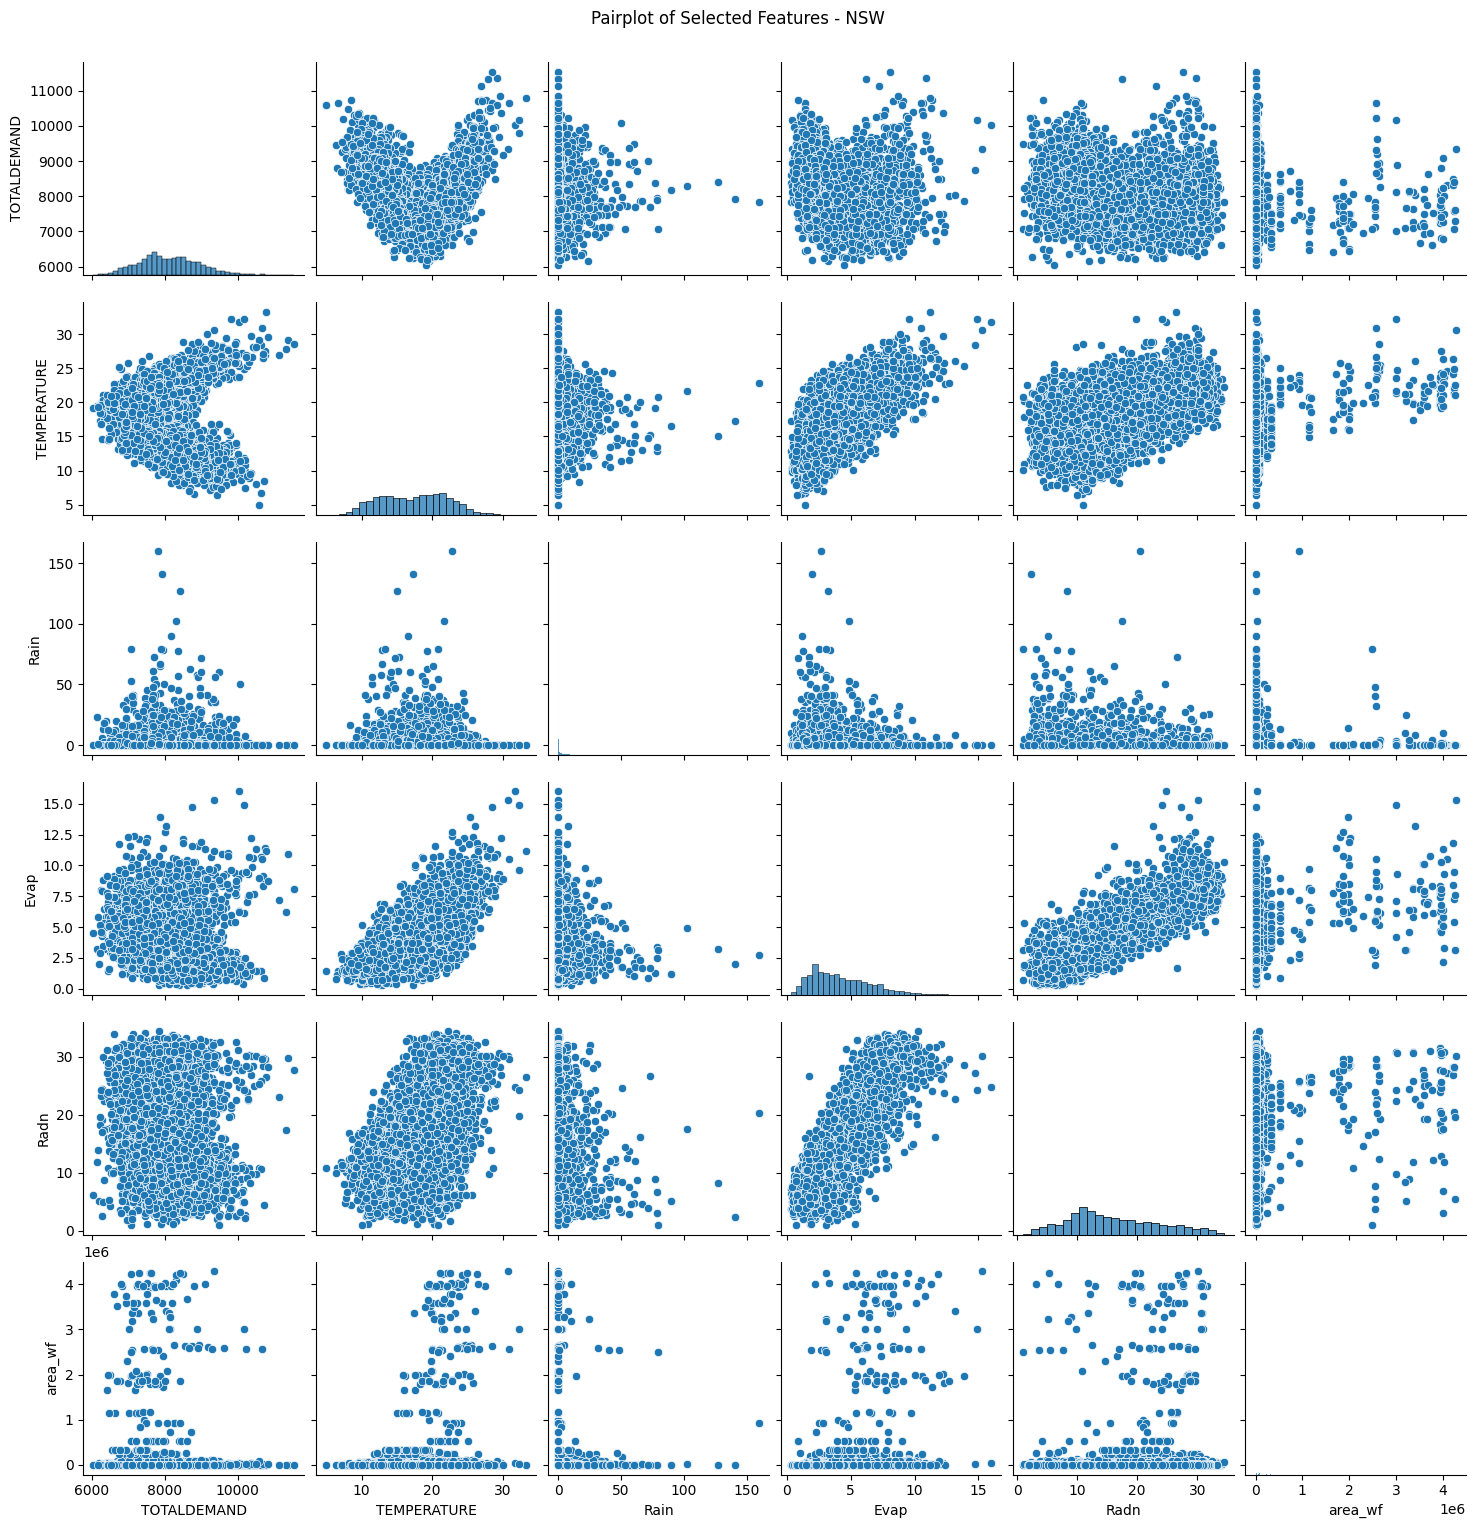

Exploratory Data Analysis for QLD

Basic Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4095 entries, 2010-01-01 to 2021-03-18
Freq: D
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOTALDEMAND  4095 non-null   float64
 1   TEMPERATURE  4088 non-null   float64
 2   Rain         4095 non-null   float64
 3   Evap         4095 non-null   float64
 4   Radn         4095 non-null   float64
 5   VP           4095 non-null   float64
 6   RH           4095 non-null   float64
 7   count_wf     4095 non-null   int64  
 8   area_wf      4095 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 319.9 KB
None

Summary Statistics:
       TOTALDEMAND  TEMPERATURE         Rain         Evap         Radn  \
count  4095.000000  4088.000000  4095.000000  4095.000000  4095.000000   
mean   6026.476530    20.364567     2.855751     5.417021    18.922784   
std     496.486205     4.215623    10.267866     2.5

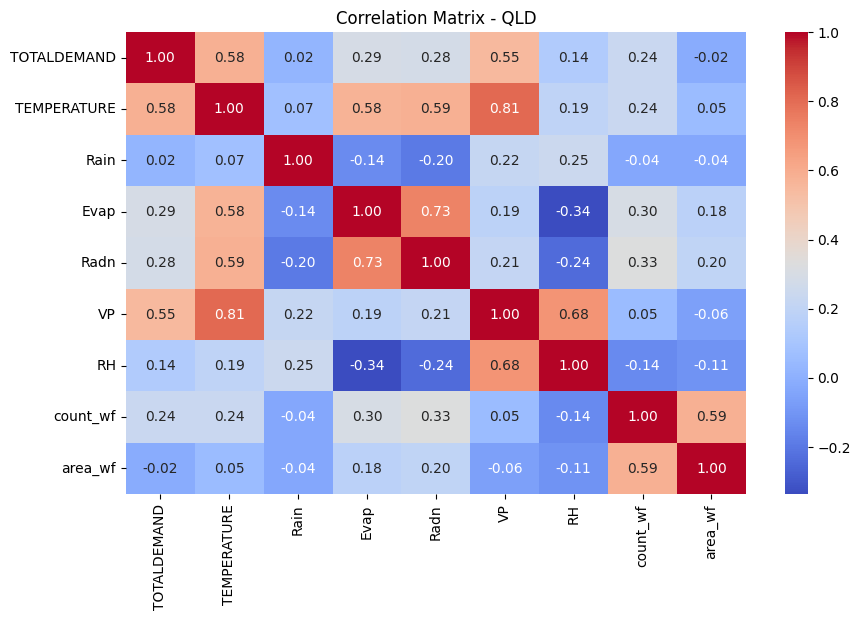

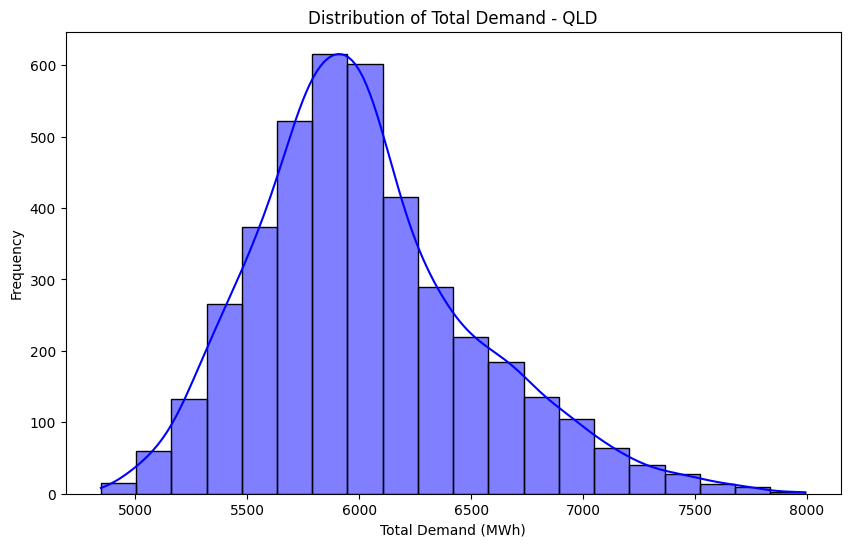

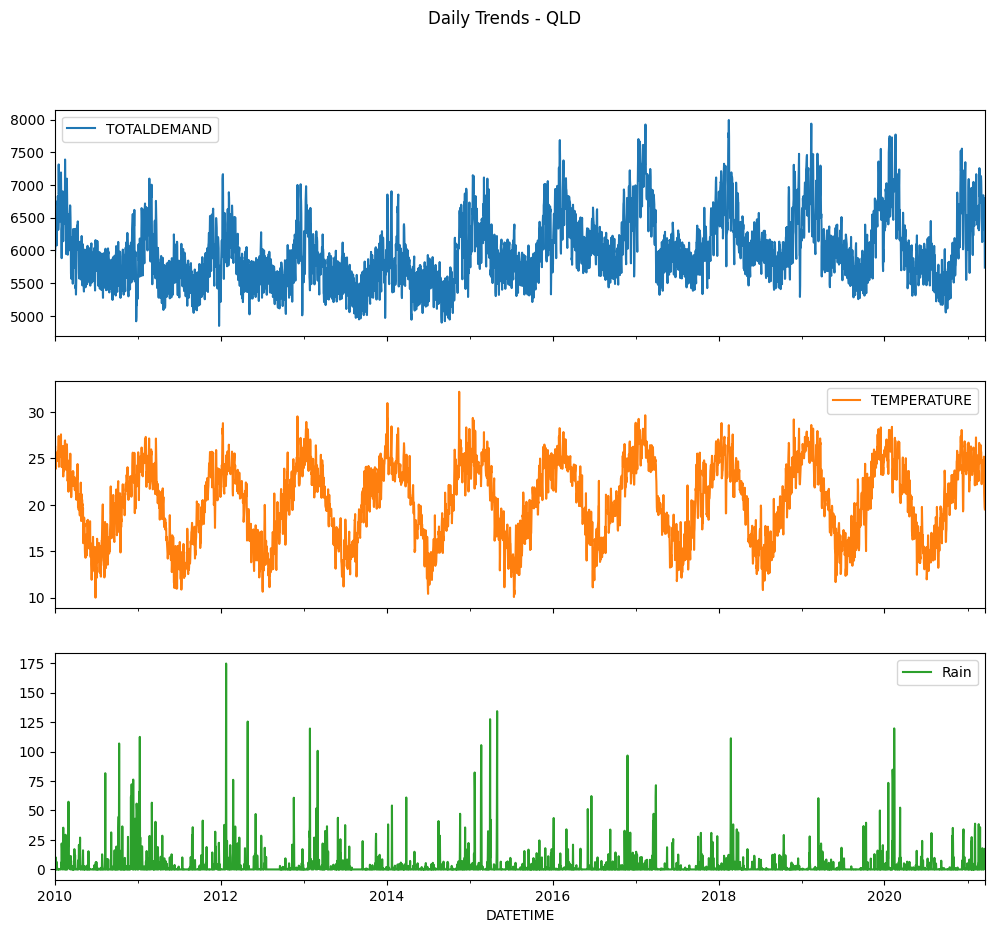

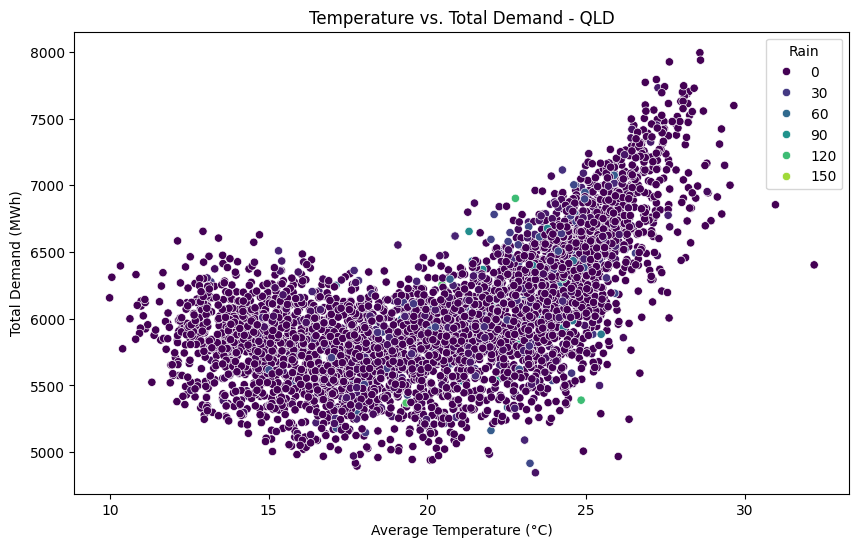

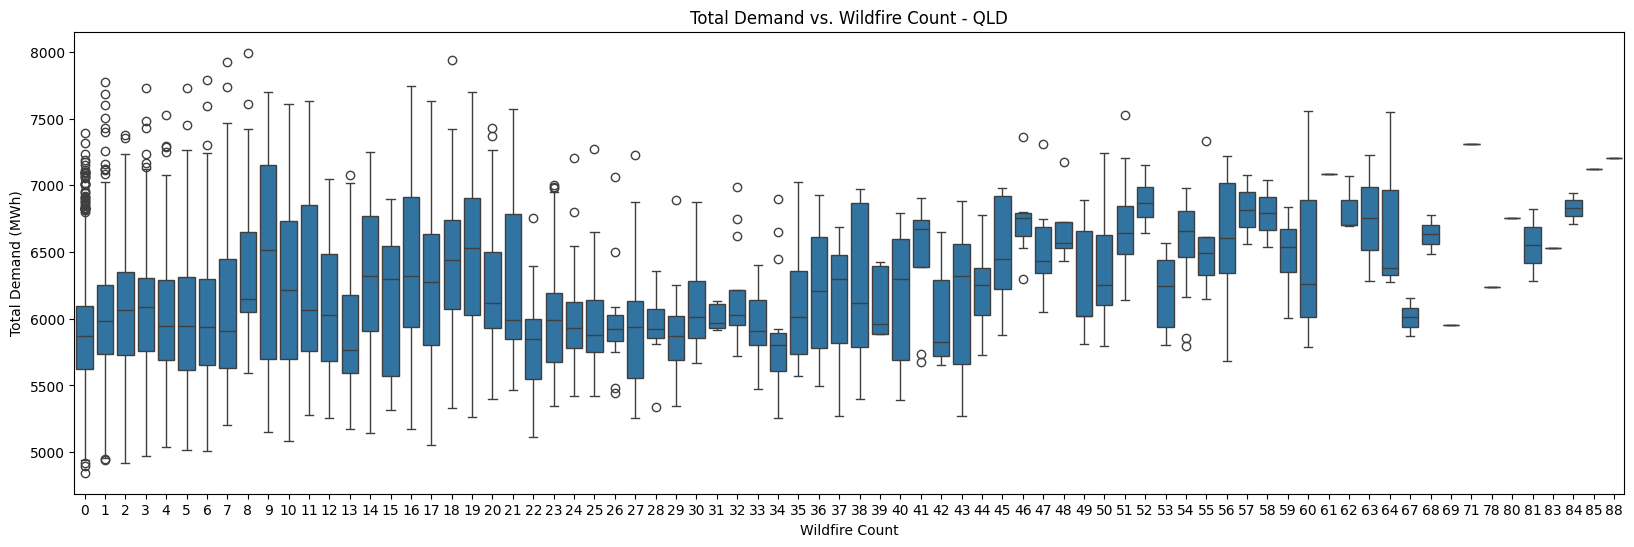

<Figure size 1200x800 with 0 Axes>

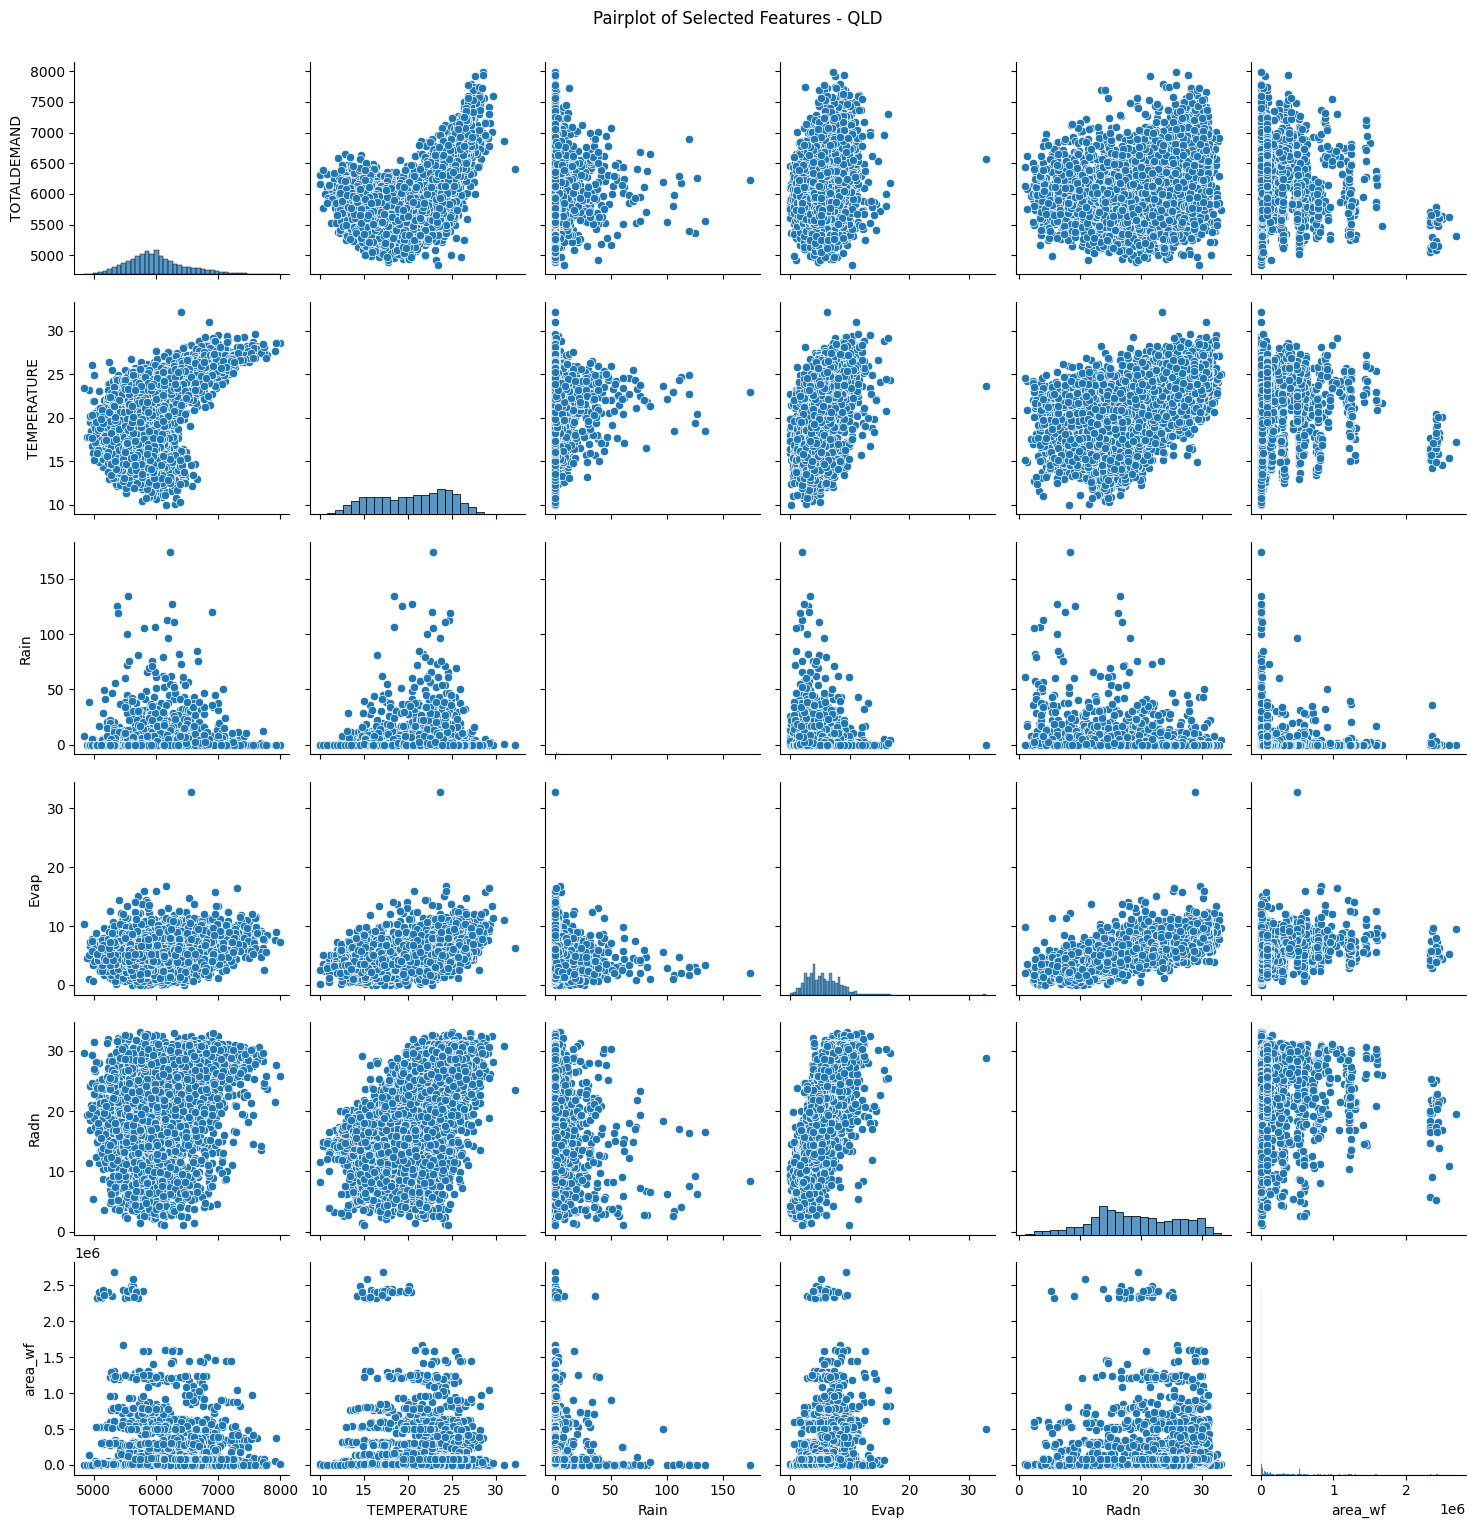

In [21]:
# Function to perform EDA on a given DataFrame
def perform_eda(df, region_name):
    """Perform exploratory data analysis on the given DataFrame."""
    print(f"Exploratory Data Analysis for {region_name}")
    print("="*50)

    # Display basic info and statistics
    print("\nBasic Information:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Correlation matrix
    print("\nCorrelation Matrix:")
    correlation = df.corr()
    print(correlation)

    # Heatmap of the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"Correlation Matrix - {region_name}")
    plt.show()

    # Distribution of TOTALDEMAND
    plt.figure(figsize=(10, 6))
    sns.histplot(df['TOTALDEMAND'], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of Total Demand - {region_name}")
    plt.xlabel("Total Demand (MWh)")
    plt.ylabel("Frequency")
    plt.show()

    # Line plot of TOTALDEMAND, TEMPERATURE, and Rain over time
    df[['TOTALDEMAND', 'TEMPERATURE', 'Rain']].plot(subplots=True, layout=(3, 1), figsize=(12, 10), title=f"Daily Trends - {region_name}")
    plt.show()

    # Scatter plot of TEMPERATURE vs. TOTALDEMAND
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='TEMPERATURE', y='TOTALDEMAND', hue='Rain', palette='viridis')
    plt.title(f"Temperature vs. Total Demand - {region_name}")
    plt.xlabel("Average Temperature (°C)")
    plt.ylabel("Total Demand (MWh)")
    plt.show()

    # Box plot of TOTALDEMAND by count_wf (Wildfire count)
    plt.figure(figsize=(20, 6))
    sns.boxplot(data=df, x='count_wf', y='TOTALDEMAND')
    plt.title(f"Total Demand vs. Wildfire Count - {region_name}")
    plt.xlabel("Wildfire Count")
    plt.ylabel("Total Demand (MWh)")
    plt.show()

    # Pairplot of selected features
    plt.figure(figsize=(12, 8))
    sns.pairplot(df[['TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'area_wf']])
    plt.suptitle(f"Pairplot of Selected Features - {region_name}", y=1.02)
    plt.show()

# Perform EDA for NSW
perform_eda(daily_merged_nsw, "NSW")

# Perform EDA for QLD
perform_eda(daily_merged_qld, "QLD")